<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Load Data</a></span></li></ul></li><li><span><a href="#Upsampling-Strategies" data-toc-modified-id="Upsampling-Strategies-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Upsampling Strategies</a></span><ul class="toc-item"><li><span><a href="#Plain-upsampling" data-toc-modified-id="Plain-upsampling-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Plain upsampling</a></span></li><li><span><a href="#SMOTE" data-toc-modified-id="SMOTE-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>SMOTE</a></span></li></ul></li><li><span><a href="#Train-test-split" data-toc-modified-id="Train-test-split-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train test split</a></span></li><li><span><a href="#Standarize-the-features-for-logistic-regression" data-toc-modified-id="Standarize-the-features-for-logistic-regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Standarize the features for logistic regression</a></span></li><li><span><a href="#Classification-modeling" data-toc-modified-id="Classification-modeling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Classification modeling</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Adjust-feature-selection-by-removing-unimportant-features" data-toc-modified-id="Adjust-feature-selection-by-removing-unimportant-features-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Adjust feature selection by removing unimportant features</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Gradient-Boosting" data-toc-modified-id="Gradient-Boosting-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Gradient Boosting</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
%matplotlib inline
sns.set(style = "whitegrid")
sns.set_palette("icefire")
plt.rcParams['figure.figsize'] = (9, 6)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings(action="ignore")

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
import sklearn.model_selection as ms
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from collections import Counter

## Load Data

In [3]:
providers = joblib.load('Providers_Final.pkl')
providers = providers.set_index('Provider')
print(providers.shape)
providers.head()

(5410, 87)


,PotentialFraud,Perc_Outpatient,DualPatientProvider,Perc_DualPatientType,Ratio_ClaimsPerPatient,Ratio_ClaimsPerAttPhys,Perc_ClaimsPerTopFraudState,Perc_HasTop5AdmtCode,PatientsPerAttPhys,PatientsPerOperPhys,PatientsPerOthPhys,Perc_MultHospAttPhys,Perc_MultHospOperPhys,Perc_MultHospOtherPhys,IP_Perc_Duplicates,IP_Count_UniquePatients,IP_Count_UniqueState,IP_Mean_AgeAtClaim,IP_Perc_HasDied,IP_Perc_GenderZero,IP_Perc_RaceOne,IP_Perc_RaceTwo,IP_Perc_RaceThree,IP_Mean_NumChronicConds,IP_Perc_Alzheimers_Chronic,IP_Perc_Cancer_Chronic,IP_Perc_Depression_Chronic,IP_Perc_Diabetes_Chronic,IP_Perc_HeartFailure_Chronic,IP_Perc_IschemicHeart_Chronic,IP_Perc_KidneyDisease_Chronic,IP_Perc_ObstrPulmonary_Chronic,IP_Perc_Osteoporosis_Chronic,IP_Perc_RheumatoidArthritis_Chronic,IP_Perc_Stroke_Chronic,IP_Perc_HasRenalDisease,IP_Mean_ClaimDuration,IP_Mean_AdmitDuration,IP_Mean_NoOfMonths_PartACov,IP_Mean_NoOfMonths_PartBCov,IP_Mean_ClaimCost,IP_Mean_DailyClaimCost,IP_Mean_DeductibleAmtPaid,IP_Mean_InscClaimAmtReimbursed,IP_Mean_InsReimbursementRatio,IP_Mean_AnnualDeductibleAmt,IP_Mean_AnnualReimbursementAmt,IP_Perc_No_ProcCode,IP_Perc_HasAllPhys,IP_Perc_HasNoPhys,IP_Perc_MultHosp,OP_Perc_Duplicates,OP_Count_UniquePatients,OP_Count_UniqueState,OP_Mean_AgeAtClaim,OP_Perc_HasDied,OP_Perc_GenderZero,OP_Perc_RaceOne,OP_Perc_RaceTwo,OP_Perc_RaceThree,OP_Mean_NumChronicConds,OP_Perc_Alzheimers_Chronic,OP_Perc_Cancer_Chronic,OP_Perc_Depression_Chronic,OP_Perc_Diabetes_Chronic,OP_Perc_HeartFailure_Chronic,OP_Perc_IschemicHeart_Chronic,OP_Perc_KidneyDisease_Chronic,OP_Perc_ObstrPulmonary_Chronic,OP_Perc_Osteoporosis_Chronic,OP_Perc_RheumatoidArthritis_Chronic,OP_Perc_Stroke_Chronic,OP_Perc_HasRenalDisease,OP_Mean_ClaimDuration,OP_Mean_NoOfMonths_PartACov,OP_Mean_NoOfMonths_PartBCov,OP_Mean_ClaimCost,OP_Mean_DailyClaimCost,OP_Mean_DeductibleAmtPaid,OP_Mean_InscClaimAmtReimbursed,OP_Mean_InsReimbursementRatio,OP_Mean_AnnualDeductibleAmt,OP_Mean_AnnualReimbursementAmt,OP_Perc_No_DiagCode,OP_Perc_HasAllPhys,OP_Perc_HasNoPhys,OP_Perc_MultHosp
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV51001,0,0.800000,1.0,0.400000,1.041667,1.785714,0.0,0.040000,10,19,16,0.240000,0.040000,0.000000,0.000000,5.0,1.0,77.600000,0.000000,0.400000,1.000000,0.000000,0.0,6.000000,0.400000,0.200000,0.800000,0.800000,0.800000,0.800000,0.800000,0.400000,0.000000,0.600000,0.400000,0.400000,6.000000,6.000000,12.000000,12.000000,20468.000000,4077.360000,1068.0,19400.000000,0.878279,897.120000,17606.000000,0.600000,0.2,0.0,0.160000,0.550000,19.0,1.0,77.950000,0.000000,0.350000,0.800000,0.200000,0.000000,5.450000,0.650000,0.200000,0.250000,0.850000,0.750000,0.950000,0.650000,0.400000,0.300000,0.250000,0.200000,0.300000,1.550000,12.000000,12.000000,382.000000,307.000000,0.000000,382.000000,1.000000,463.920000,2615.200000,0.000000,0.050000,0.000000,0.920000
PRV51003,1,0.530303,1.0,0.500000,1.128205,3.000000,0.0,0.060606,73,110,95,0.007576,0.000000,0.000000,0.016129,53.0,3.0,69.935484,0.016129,0.338710,0.790323,0.209677,0.0,4.919355,0.516129,0.112903,0.403226,0.790323,0.580645,0.887097,0.629032,0.370968,0.209677,0.306452,0.112903,0.274194,6.161290,6.161290,11.806452,11.806452,10309.935484,2384.941628,1068.0,9241.935484,0.821059,931.424242,7568.181818,0.370968,0.0,0.0,0.045455,0.357143,66.0,3.0,68.371429,0.000000,0.471429,0.828571,0.157143,0.000000,4.214286,0.342857,0.042857,0.414286,0.728571,0.628571,0.814286,0.357143,0.257143,0.285714,0.271429,0.071429,0.171429,3.357143,11.828571,11.928571,467.714286,336.440760,1.000000,466.714286,0.994032,737.121212,2678.181818,0.000000,0.057143,0.000000,0.818182
PRV51004,0,1.000000,0.0,0.208054,1.079710,3.921053,0.0,0.013423,100,119,112,0.167785,0.013423,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000

# Upsampling Strategies

## Plain upsampling

In [4]:
# # Separate majority and minority classes
# providers_majority = providers[providers['PotentialFraud'] == 0]
# providers_minority = providers[providers['PotentialFraud'] == 1]
 
# # Upsample minority class
# providers_minority_upsampled = resample(providers_minority,
#                                         replace = True,
#                                         n_samples = providers_majority.shape[0],
#                                         random_state = 0)
 
# # Combine majority class with upsampled minority class
# providers_upsampled = pd.concat([providers_majority, providers_minority_upsampled])

# # Separate input features (X) and target variable (y)
# y_upsamp = providers_upsampled['PotentialFraud']
# X_upsamp = providers_upsampled.drop('PotentialFraud', axis=1)

# # Count of target variable after upsampling
# Counter(y_upsamp)

## SMOTE

In [5]:
# Separate input features (X) and target variable (y)
y = providers['PotentialFraud']
X = providers.drop('PotentialFraud', axis=1)

# upsample minority class with SMOTE
oversample = SMOTE(random_state = 0)
X_smote, y_smote = oversample.fit_resample(X, y)

# Count of target variable after upsampling
Counter(y_smote)

Counter({0: 4904, 1: 4904})

# Train test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, 
                                                    stratify = y_smote, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Standarize the features for logistic regression

In [7]:
scaler = StandardScaler()
X_train_stan = scaler.fit_transform(X_train)
X_test_stan = scaler.transform(X_test)

# Classification modeling

In [8]:
# Stratified Cross Validation needs to be applied
skf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

In [9]:
# Model evaluation metric: Recall score
def eval_model(model, best_model, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):
    print(model,'score')
    print('-'*30)
    print('Train: recall score:', round(recall_score(y_train, best_model.predict(X_train)),5))
    print('Test: recall score:', round(recall_score(y_test, best_model.predict(X_test)),5))

## Logistic Regression

In [10]:
logistic = LogisticRegression(solver="liblinear", penalty = 'l1')

In [11]:
param_grid = [{'C': np.logspace(-5,1,100)}]
logisticcv = GridSearchCV(logistic, param_grid = param_grid, cv = skf)
para_search = logisticcv.fit(X_train_stan, y_train)
best_logistic = para_search.best_estimator_
print('Best estimator:', best_logistic)

Best estimator: LogisticRegression(C=0.012328467394420659, penalty='l1', solver='liblinear')


In [12]:
eval_model('Logistic Regression', best_logistic, X_train_stan, X_test_stan)

Logistic Regression score
------------------------------
Train: recall score: 0.88657
Test: recall score: 0.88787


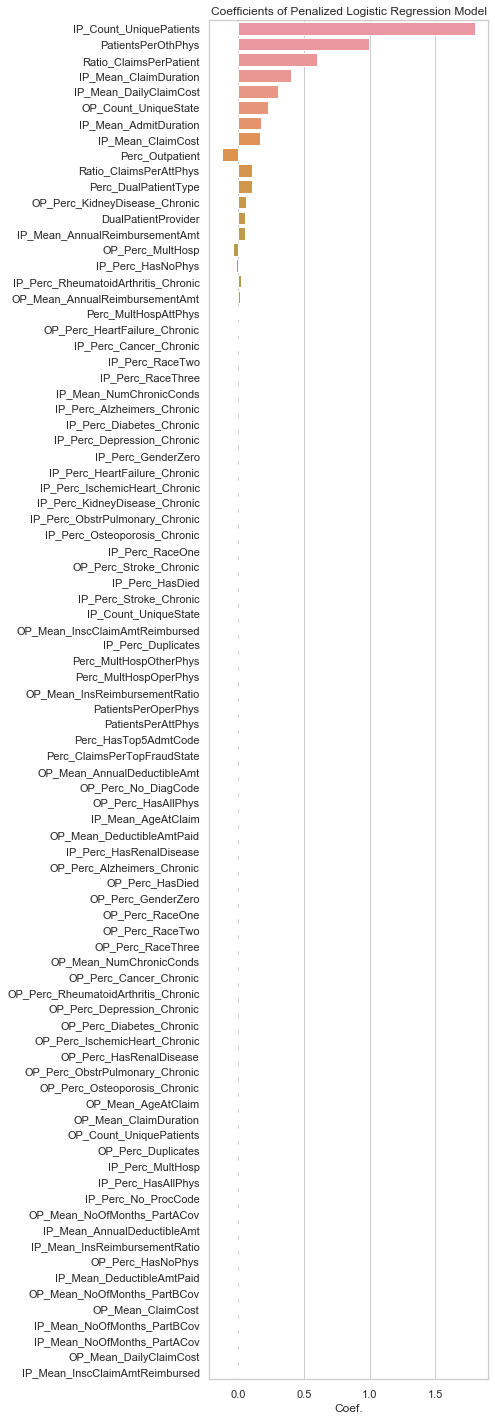

In [13]:
logistic_coef = pd.DataFrame(best_logistic.coef_.T, index = X.columns).rename(columns = {0:"Coef."})
logistic_coef = logistic_coef.reindex(logistic_coef["Coef."].abs().sort_values(ascending = False).index)
plt.figure(figsize = (5,25))
sns.barplot(data = logistic_coef.reset_index(), x = 'Coef.', y = 'index');
plt.title('Coefficients of Penalized Logistic Regression Model');
plt.ylabel('');

## Adjust feature selection by removing unimportant features 

In [14]:
logistic_coef = logistic_coef.reset_index()
notimportant = logistic_coef[logistic_coef['Coef.'].abs() == 0]['index'].tolist()
print('Number of unimportant features distilled by lasso:', len(notimportant))

Number of unimportant features distilled by lasso: 66


In [15]:
# Reset the dataset with selective columns
X_train_reduced = X_train.iloc[:,~X_train.columns.isin(notimportant)]
X_test_reduced = X_test.iloc[:,~X_test.columns.isin(notimportant)]

In [16]:
print('Number of features after removing unimportant features:', X_train_reduced.shape[1])

Number of features after removing unimportant features: 20


## Random Forest

In [17]:
randomForest = RandomForestClassifier(random_state = 0)
grid_para_forest = {'n_estimators': [100,500,1000,2500,5000],
                   'max_depth': [15,20,30,40],
                   'max_features' : [5,7,10]}

In [18]:
grid_search_forest = GridSearchCV(randomForest, 
                                  grid_para_forest,
                                  cv=skf, n_jobs = 5, verbose = 1)
para_search = grid_search_forest.fit(X_train_reduced, y_train)
best_rf = para_search.best_estimator_
print('Best parameters:', para_search.best_params_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed: 17.5min finished


Best parameters: {'max_depth': 30, 'max_features': 5, 'n_estimators': 500}


In [19]:
eval_model('Random Forest', best_rf, X_train_reduced, X_test_reduced)

Random Forest score
------------------------------
Train: recall score: 1.0
Test: recall score: 0.97757


In [20]:
confusion_matrix(y_train,best_rf.predict(X_train_reduced))

array([[3923,    0],
       [   0, 3923]])

In [21]:
confusion_matrix(y_test,best_rf.predict(X_test_reduced))

array([[936,  45],
       [ 22, 959]])

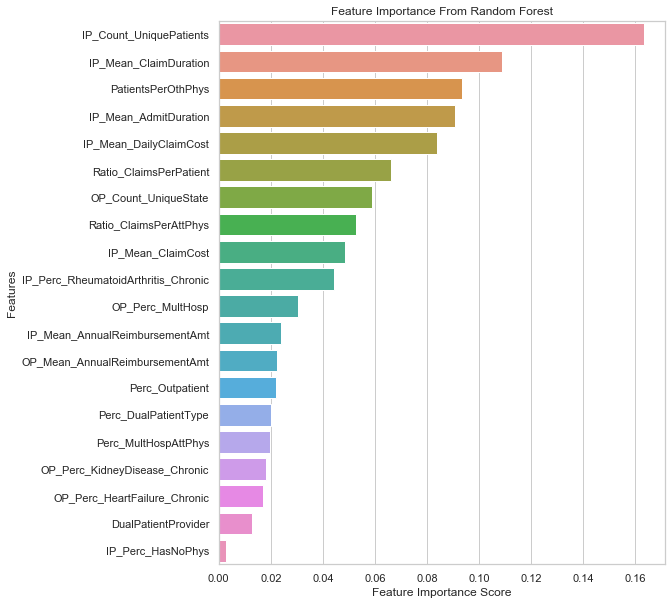

In [22]:
sorted_importance = sorted(zip(X_train_reduced.columns, best_rf.feature_importances_), key=lambda t:t[1], reverse=True)
a, b = zip(*sorted_importance)
plt.figure(figsize = (8,10))
df = pd.DataFrame({'feature_name':a, 'importance_score':b})
sns.barplot(data = df, x = 'importance_score', y= 'feature_name', orient = 'h');
plt.title('Feature Importance From Random Forest');
plt.xlabel('Feature Importance Score');
plt.ylabel('Features');

In [23]:
# joblib.dump(best_rf,'best_rf1.pkl')

## Gradient Boosting

In [24]:
gbm = GradientBoostingClassifier(random_state = 0)
grid_para_gb = {'n_estimators': [100,500,1000,2500,5000],
                   'learning_rate':[0.01,0.05,0.1],
                   'max_depth':range(1,6),
                   'max_features' : [5,7,15]}

In [25]:
grid_search_gb = GridSearchCV(gbm, 
                              grid_para_gb, 
                              cv= skf, n_jobs = 5, verbose = 1)
para_search = grid_search_gb.fit(X_train_reduced, y_train)
best_gb = para_search.best_estimator_
print('Best parameters:', para_search.best_params_)

Fitting 3 folds for each of 225 candidates, totalling 675 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   39.5s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  7.7min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 20.4min
[Parallel(n_jobs=5)]: Done 675 out of 675 | elapsed: 34.0min finished


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 7, 'n_estimators': 5000}


In [26]:
eval_model('Gradient Boosting', best_gb, X_train_reduced, X_test_reduced)

Gradient Boosting score
------------------------------
Train: recall score: 1.0
Test: recall score: 0.98063


In [27]:
confusion_matrix(y_train,best_gb.predict(X_train_reduced))

array([[3923,    0],
       [   0, 3923]])

In [28]:
confusion_matrix(y_test,best_gb.predict(X_test_reduced))

array([[944,  37],
       [ 19, 962]])

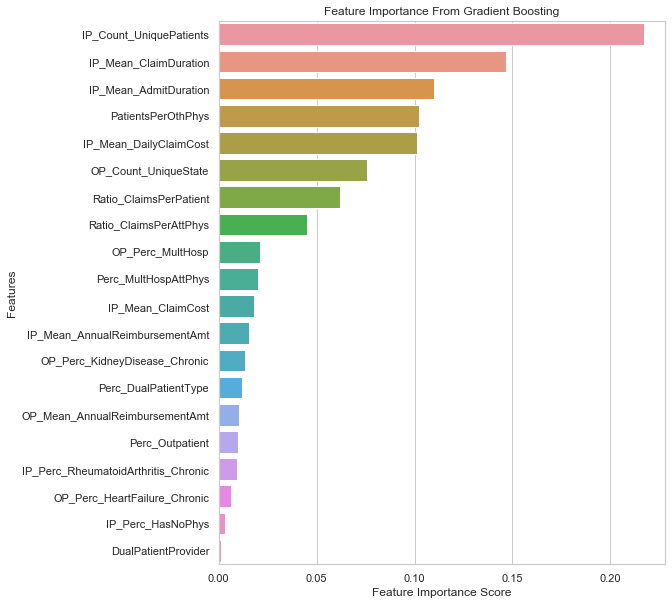

In [29]:
sorted_importance = sorted(zip(X_train_reduced.columns, best_gb.feature_importances_), key=lambda t:t[1], reverse=True)
a, b = zip(*sorted_importance)
plt.figure(figsize = (8,10))
df = pd.DataFrame({'feature_name':a, 'importance_score':b})
sns.barplot(data = df, x = 'importance_score', y= 'feature_name', orient = 'h');
plt.title('Feature Importance From Gradient Boosting');
plt.xlabel('Feature Importance Score');
plt.ylabel('Features');

In [30]:
# joblib.dump(best_gb,'best_gb1.pkl')